# Predicting Tornado instances

In [2]:
import sys
import os

# Add the parent directory of 'src' to the Python path
sys.path.append('/Users/evansweeney/Desktop/492_project_local/cmse492_project')

# Now you can import from src
from src.windowing import WindowGenerator


import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Loading in data that we processed
df = pd.read_csv('/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/KansasStationProcessed.csv',index_col=0, parse_dates=[0])

Total samples: 52608
Training samples: 36825
Validation samples: 10522
Test samples: 5261
Number of features: 17


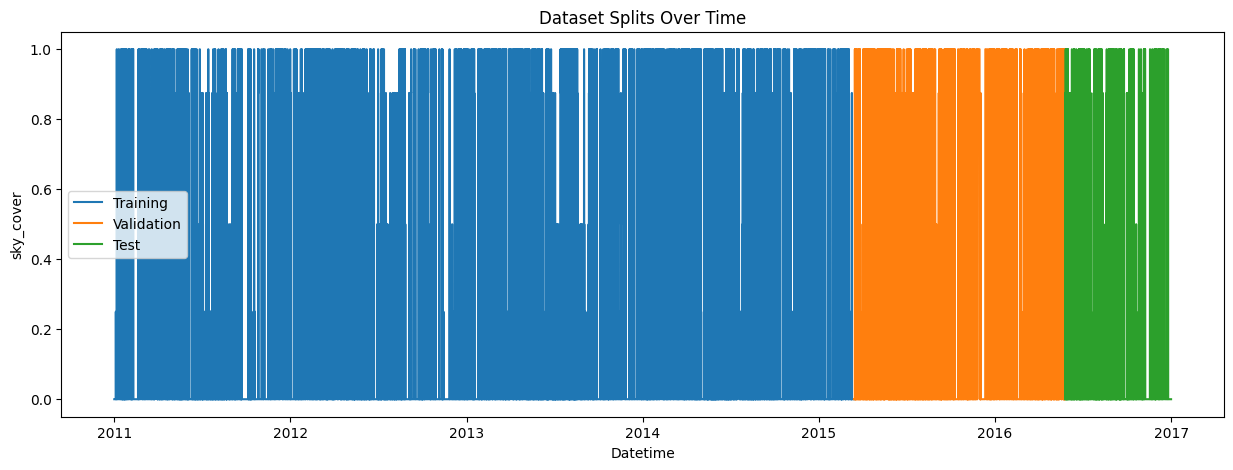

In [4]:
df = df.sort_index()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f"Total samples: {n}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

num_features = df.shape[1]
print(f"Number of features: {num_features}")

# Plotting temperature over time to make sure everything worked
plt.figure(figsize=(15, 5))
plt.plot(train_df.index, train_df['sky_cover'], label='Training')
plt.plot(val_df.index, val_df['sky_cover'], label='Validation')
plt.plot(test_df.index, test_df['sky_cover'], label='Test')
plt.xlabel('Datetime')
plt.ylabel('sky_cover')
plt.legend()
plt.title('Dataset Splits Over Time')
plt.show()

### RNN

In [22]:
df.columns

Index(['temperature', 'dew_point_temperature', 'wet_bulb_temperature',
       'station_level_pressure', 'sea_level_pressure', 'wind_gust',
       'relative_humidity', 'precipitation', 'visibility', 'sky_cover',
       'sky_cover_baseht', 'Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin',
       'Year cos'],
      dtype='object')

In [13]:
OUT_STEPS = 24  # Number of output steps

multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['Wx']  # Specify 'sky_cover' as the label
)


In [14]:
num_features = train_df.shape[1] 
num_labels = len(multi_window.label_columns)  


In [15]:
multi_lstm_model = tf.keras.Sequential([
    # Input shape: [batch, time, features]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Output shape: [batch, OUT_STEPS * num_labels]
    tf.keras.layers.Dense(OUT_STEPS * num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Reshape to [batch, OUT_STEPS, num_labels]
    tf.keras.layers.Reshape([OUT_STEPS, num_labels])
])


In [16]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(
        window.train,
        epochs=20,
        validation_data=window.val,
        callbacks=[early_stopping])
    return history


In [17]:
history = compile_and_fit(multi_lstm_model, multi_window)


Epoch 1/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1333 - mean_absolute_error: 0.2719 - val_loss: 0.1392 - val_mean_absolute_error: 0.2891
Epoch 2/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1211 - mean_absolute_error: 0.2613 - val_loss: 0.1388 - val_mean_absolute_error: 0.2832
Epoch 3/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1202 - mean_absolute_error: 0.2590 - val_loss: 0.1367 - val_mean_absolute_error: 0.2881
Epoch 4/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1196 - mean_absolute_error: 0.2578 - val_loss: 0.1400 - val_mean_absolute_error: 0.2831
Epoch 5/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1238 - mean_absolute_error: 0.2663 - val_loss: 0.1389 - val_mean_absolute_error: 0.2814


328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1381 - mean_absolute_error: 0.2953


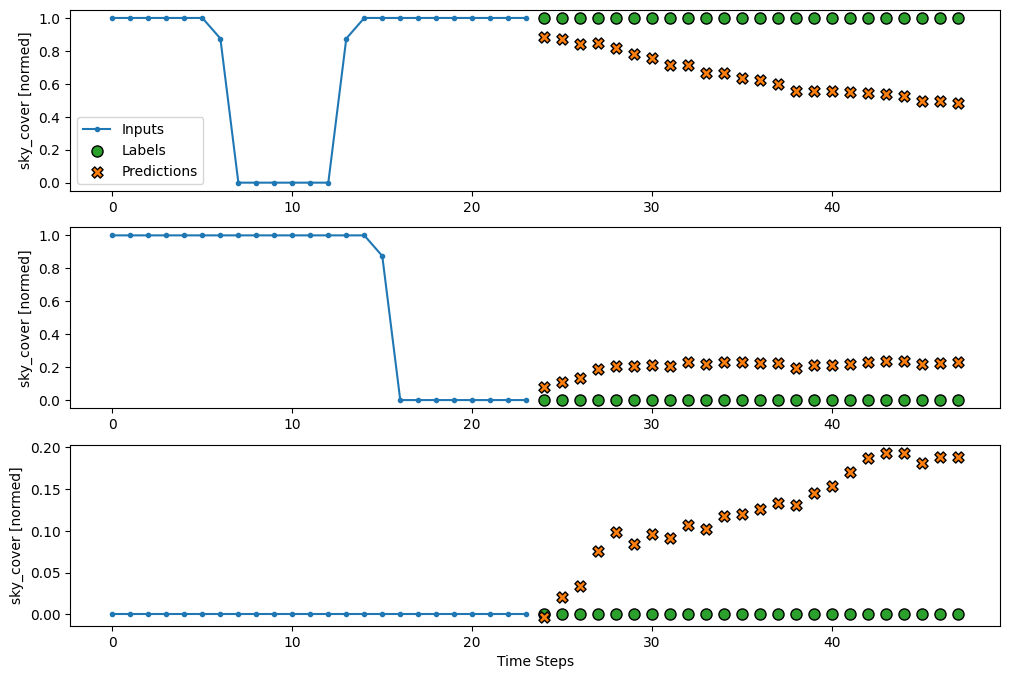

In [21]:
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

# Evaluate on validation data
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True)

# Evaluate on test data
multi_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)

# Plot predictions for 'sky_cover'
multi_window.plot(multi_lstm_model, plot_col='Wx')

#### Testing Wx and Wy

Epoch 1/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 19.6877 - mean_absolute_error: 3.4506 - val_loss: 16.9723 - val_mean_absolute_error: 3.2133
Epoch 2/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 17.0601 - mean_absolute_error: 3.1792 - val_loss: 15.7587 - val_mean_absolute_error: 3.0590
Epoch 3/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 15.8988 - mean_absolute_error: 3.0386 - val_loss: 15.1507 - val_mean_absolute_error: 2.9883
Epoch 4/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 15.3829 - mean_absolute_error: 2.9714 - val_loss: 14.8249 - val_mean_absolute_error: 2.9525
Epoch 5/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 15.1675 - mean_absolute_error: 2.9421 - val_loss: 14.6370 - val_mean_absolute_error: 2.9000
Epoch 6/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 14.9524 - mean_absolute_error: 2.9146 - val_loss: 14.5319 - val_mean_absolute_error: 2.9131
Epoch 7/20
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 14.8692 - mean

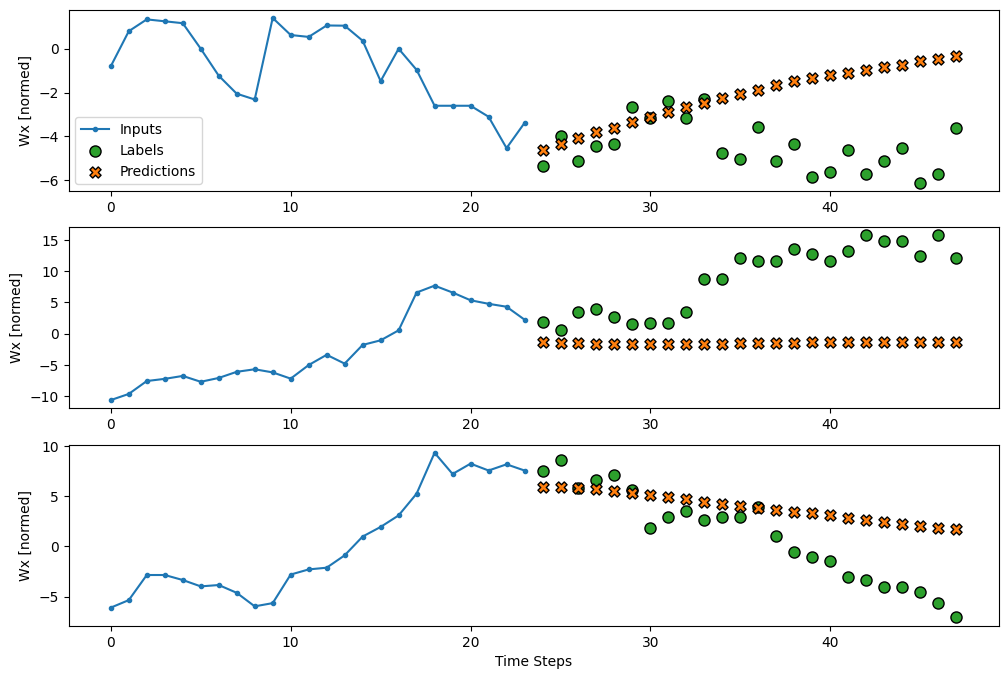

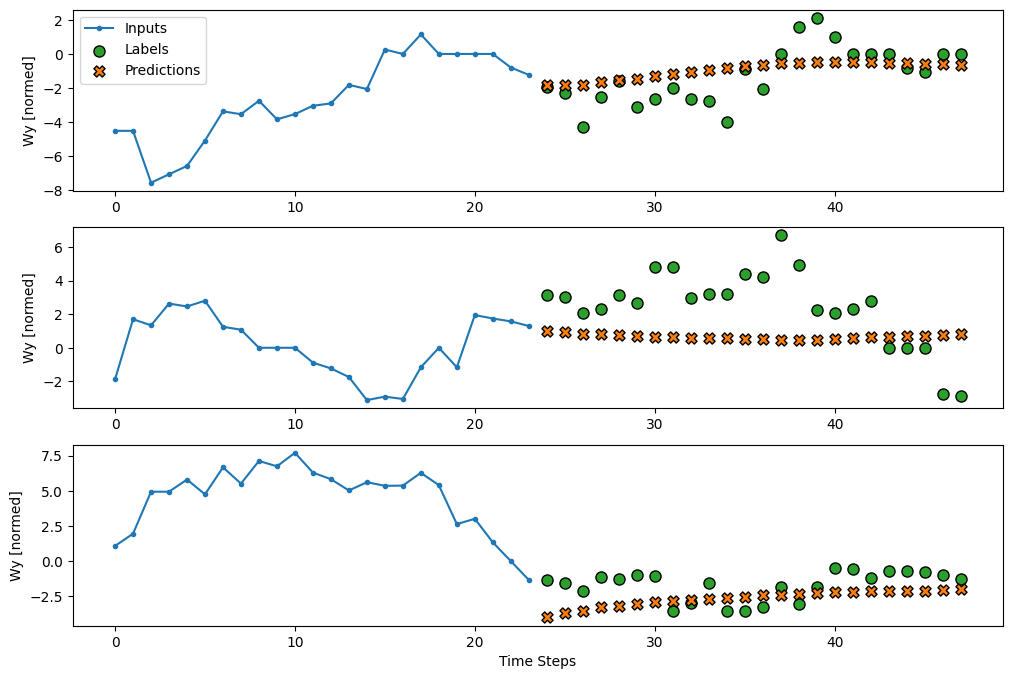

In [23]:
OUT_STEPS = 24  # Number of output steps

multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['Wx', 'Wy']  # Include both 'Wx' and 'Wy' as labels
)

num_features = train_df.shape[1] 
num_labels = len(multi_window.label_columns)  # Now this is 2

multi_lstm_model = tf.keras.Sequential([
    # Input shape: [batch, time, features]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Output shape: [batch, OUT_STEPS * num_labels]
    tf.keras.layers.Dense(OUT_STEPS * num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Reshape to [batch, OUT_STEPS, num_labels]
    tf.keras.layers.Reshape([OUT_STEPS, num_labels])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# Evaluate on validation data
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.val, return_dict=True)

# Evaluate on test data
multi_performance['LSTM'] = multi_lstm_model.evaluate(
    multi_window.test, verbose=0, return_dict=True)

# Plot predictions for 'Wx' and 'Wy'
multi_window.plot(multi_lstm_model, plot_col='Wx')
multi_window.plot(multi_lstm_model, plot_col='Wy')
